In [43]:
#dépendances
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

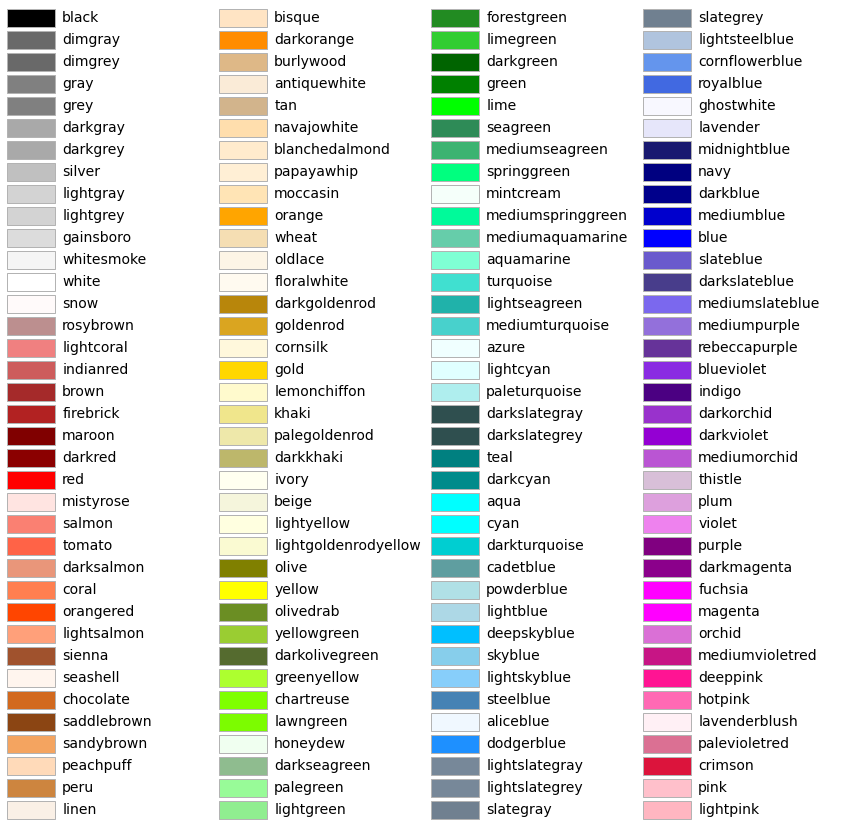

In [44]:
plot_colortable(mcolors.CSS4_COLORS)
plt.show()

# Multi-Class Prediction of Cirrhosis Outcomes

## Utilize 17 clinical features for predicting survival state of patients with liver cirrhosis.
The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).

###  For what purpose was the dataset created?

Cirrhosis results from prolonged liver damage, leading to extensive scarring, often due to conditions like hepatitis or chronic alcohol consumption. The data provided is sourced from a Mayo Clinic study on primary biliary cirrhosis (PBC) of the liver carried out from 1974 to 1984.

### Who funded the creation of the dataset?

Mayo Clinic

###  What do the instances in this dataset represent?

People

###  Does the dataset contain data that might be considered sensitive in any way?

Gender, Age

###  Additional Information

During 1974 to 1984, 424 PBC patients referred to the Mayo Clinic qualified for the randomized placebo-controlled trial testing the drug D-penicillamine. Of these, the initial 312 patients took part in the trial and have mostly comprehensive data. The remaining 112 patients didn't join the clinical trial but agreed to record basic metrics and undergo survival tracking. Six of these patients were soon untraceable after their diagnosis, leaving data for 106 of these individuals in addition to the 312 who were part of the randomized trial.

###  Objective:

Understand the dataset and perform any necessary cleanup.
Build a classification model to predict the Cirrhosis Outcomes.
Fine-tune hyperparameters and compare the evaluation metrics of various classification algorithms.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = r"C:\Users\Frederic\Documents\GitHub\Tennis_analysis\Prediction-of-Cirrhosis-Outcomes"
train_path = os.path.abspath(path) + "/data" +"/train.csv"
test_path = os.path.abspath(path) + "/data" +"/test.csv"
print(train_path)
print(test_path)

C:\Users\Frederic\Documents\GitHub\Tennis_analysis\Prediction-of-Cirrhosis-Outcomes/data/train.csv
C:\Users\Frederic\Documents\GitHub\Tennis_analysis\Prediction-of-Cirrhosis-Outcomes/data/test.csv


In [3]:
df_train=pd.read_csv(train_path,index_col='id')
df_train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [5]:
def find_col_dtypes(df, target, limit = 10):
    """
    Fonction qui selectionne les colonnes numériques et catégorielles dans un df
    Lorsque le nombre de valeur unique d'un catégorie est > limit, on la considère comme une variable numérique
    """
    num_cols = df.select_dtypes("number").columns.to_list()
    cat_cols = df.select_dtypes("object").columns.to_list()
    cardinals = [col for col in cat_cols if df[col].nunique() == df.shape[0]]
    cat_but_num = [col for col in cat_cols if (df[col].nunique() >= limit) & (col not in cardinals)] #variables catégorielles av nb de valeurs >10
    cat_cols = [col for col in df.columns if (df[col].nunique() < limit) & (col not in [target])]  #variables catégorielles av nb de valeurs <10
    num_cols = [col for col in num_cols if (col not in cat_cols) & (col not in [target])] + cat_but_num #variable numériques et variables catégorielles av nb de valeurs >10 
    print(f"Colonnes numériques : {num_cols}", end="\n\n")
    print("Voici le type des colonnes numériques:")
    df[num_cols].info()
    
    print("\n")
    
    print(f"Colonnes catégorielles : {cat_cols}")
    print("Voici le type des colonnes catégorielles:",end="\n\n")
    df[cat_cols].info()
    
    #cast types
    return num_cols, cat_cols

def exploration(df):
    #valeurs manquantes
    print(f"Il y a {df.isnull().sum().sum()} valeurs manquantes"+"\n")
    if (df.isnull().sum().sum()) >0:
        print(df.isnull().sum())
    #lignes dupliquées
    print(f"Il y a {df.duplicated().sum().sum()} lignes dupliquées")
    if (df.duplicated().sum().sum())>0:
        print(df.duplicated().sum())

In [41]:
#cas d'espèce
limit = 8
target = "Status"
num_cols, cat_cols = find_col_dtypes(df=df_train, target=target,limit=limit)

Colonnes numériques : ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

Voici le type des colonnes numériques:
<class 'pandas.core.frame.DataFrame'>
Index: 7905 entries, 0 to 7904
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Age            7905 non-null   int64  
 2   Bilirubin      7905 non-null   float64
 3   Cholesterol    7905 non-null   float64
 4   Albumin        7905 non-null   float64
 5   Copper         7905 non-null   float64
 6   Alk_Phos       7905 non-null   float64
 7   SGOT           7905 non-null   float64
 8   Tryglicerides  7905 non-null   float64
 9   Platelets      7905 non-null   float64
 10  Prothrombin    7905 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 741.1 KB


Colonnes catégorielles : ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',

In [48]:
df_train['Stage'].unique()

array([3., 4., 2., 1.])

C:\Users\Frederic\AppData\Local\Temp\ipykernel_19040\4091898390.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=df_train['Stage'].unique(),horizontalalignment='right')


Text(0, 0.5, 'Nombre')

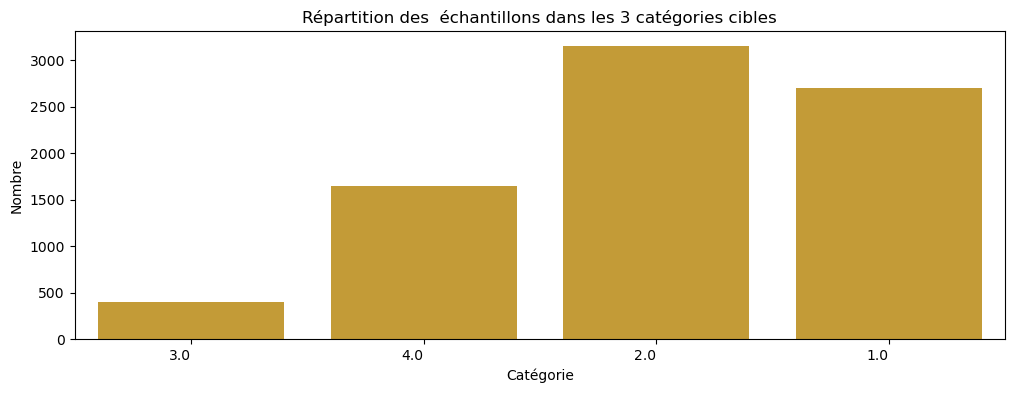

In [49]:
# Affichage des diagrammes en barres pour la variable 'stage
plt.figure(figsize=(12, 4))

# Diagramme en barres pour la Catégorie 1
plt.subplot(1, 1, 1)
ax = sns.countplot(data=df_train, x = 'Stage', color='goldenrod')
plt.title('Répartition des  échantillons dans les 3 catégories cibles')
plt.xlabel('Catégorie')
ax.set_xticklabels(labels=df_train['Stage'].unique(),horizontalalignment='right')
plt.ylabel('Nombre')

In [50]:
df_train['Stage']=df_train['Stage'].astype('object')

In [21]:
df_train[target].value_counts()

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

C:\Users\Frederic\AppData\Local\Temp\ipykernel_19040\1226732935.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=['Death','censored','censored due to liver transplantation'],horizontalalignment='right')


Text(0, 0.5, 'Nombre')

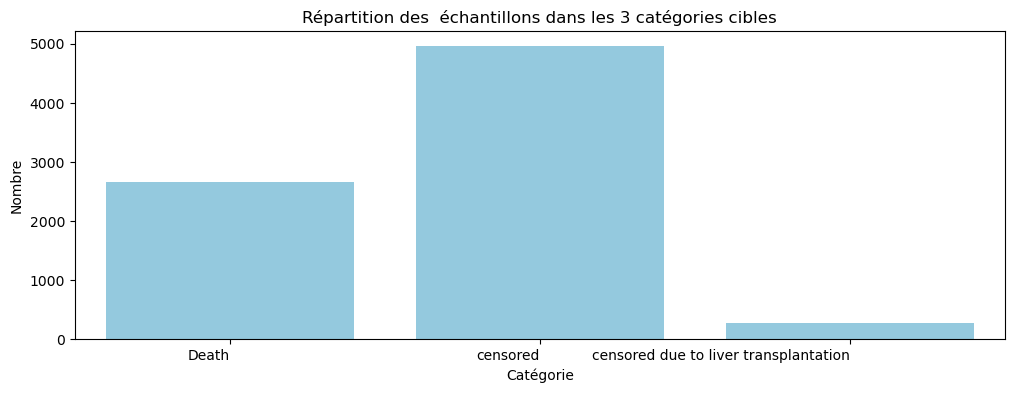

In [34]:
# Affichage des diagrammes en barres pour chaque variable catégorielle
plt.figure(figsize=(12, 4))

# Diagramme en barres pour la Catégorie 1
plt.subplot(1, 1, 1)
ax = sns.countplot(data=df_train, x = target, color='skyblue')
plt.title('Répartition des  échantillons dans les 3 catégories cibles')
plt.xlabel('Catégorie')
ax.set_xticklabels(labels=['Death','censored','censored due to liver transplantation'],horizontalalignment='right')
plt.ylabel('Nombre')


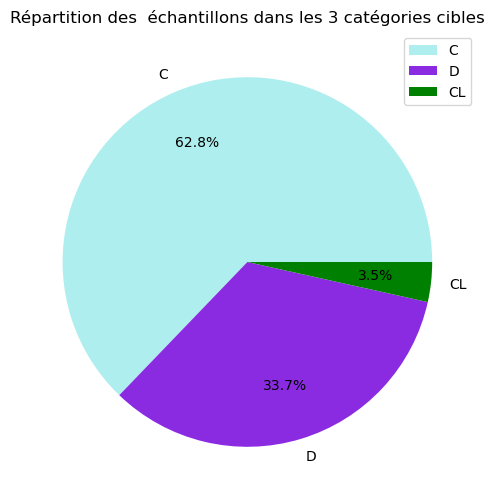

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))

plt.pie(df_train[target].value_counts(),labels = [df_train[target].unique()[1],df_train[target].unique()[0],df_train[target].unique()[2] ],
        colors=['paleturquoise', 'blueviolet','green'],
        autopct='%1.1f%%',
        pctdistance=0.7)
plt.title('Répartition des  échantillons dans les 3 catégories cibles')
plt.legend();

### Nan, lignes dupliquées

In [8]:
exploration(df_train)

Il y a 0 valeurs manquantes

Il y a 0 lignes dupliquées


## variables catégorielles

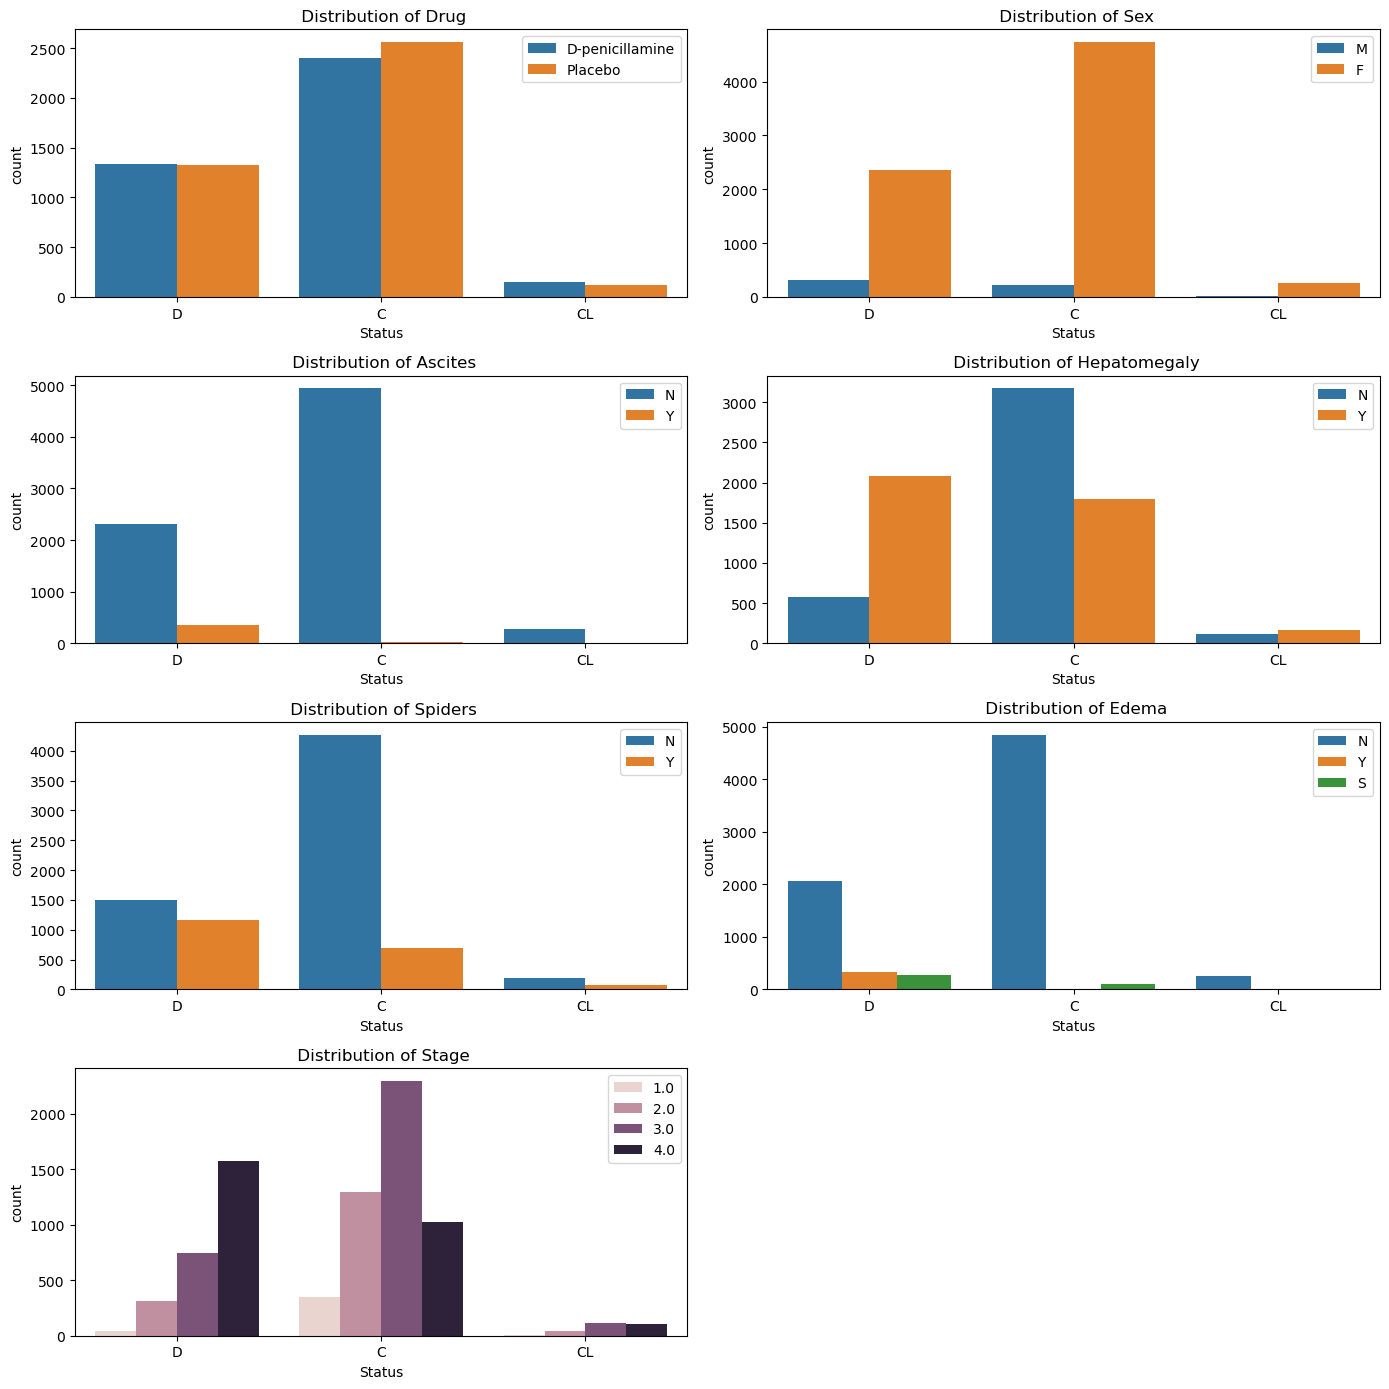

In [14]:
plt.figure(figsize=(14,len(cat_cols)*2))
for idx,column in enumerate(cat_cols):
        plt.subplot((len(cat_cols)//2)+1,2,idx+1)
        sns.countplot(df_train, x=target, hue=column)
        plt.title(f" Distribution de {column}")
        plt.tight_layout()
        plt.legend()


In [5]:
#Variables catégorielles

In [6]:
df['Drug'].value_counts()

Drug
Placebo            4010
D-penicillamine    3895
Name: count, dtype: int64

In [7]:
df['Drug'].unique()[1]

'Placebo'

In [8]:
import plotly.graph_objects as go
colors=['paleturquoise', 'blueviolet']

fig=go.Figure()
fig.add_trace(go.Pie(labels = [df['Drug'].unique()[1],df['Drug'].unique()[0]],
values = df['Drug'].value_counts(),
marker_colors = colors,  # Couleur de chaque partie du camembert 
# pull = [0.2,0] # Partie à éloigner du camembert 
                      ))
fig.show;

In [33]:
df['Sex'].value_counts()

Sex
F    7336
M     569
Name: count, dtype: int64

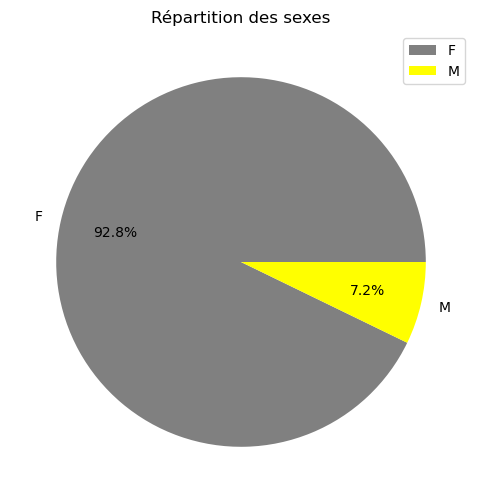

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))

plt.pie(df['Sex'].value_counts(),labels = [df['Sex'].unique()[1],df['Sex'].unique()[0]],
        colors=['grey', 'yellow'],
        autopct='%1.1f%%',
        pctdistance=0.7)
plt.title('Répartition des sexes')
plt.legend();

In [34]:
df['Ascites'].value_counts()

Ascites
N    7525
Y     380
Name: count, dtype: int64